In [463]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from scipy import stats


from sklearn import svm
from sklearn.model_selection import train_test_split

import sys
sys.path.append("/Users/lsp/Documents/projets/en_cours/eeg/eeg")
from eeg import create3DMatrix, loadEEG, getEvents, getTrialNumList, plotFFTElectrodes, plot3DMatrix, computePickEnergy

sys.path.append("/Users/lsp/Documents/projets/en_cours/eeg/dss")
from dss import crossValidateDSS, createBiasedSignal

from tools.eeg_utils import processEEG, loadDataH5
from tools.audio import getAttendedAndUnattendedEnv
from tools.behavior import getBehaviorData, analyses, checkLinkTrialsBehaviorEEG, getTrialNum
from tools.decodingTRF import getTRFAccuracyByDur, getUnattendedTrialsNumber, calculateCorr
from tools.decodingSSR import calculateBaseline, comparePicks, getSSRAccuracyByDur, crossVal


In [464]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [465]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [466]:
%matplotlib notebook

In [467]:
# Plot parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 10)

Populating the interactive namespace from numpy and matplotlib


/Users/lsp/.virtualenvs/eeg/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['xlim', 'clf', 'ylim', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Background

In this notebook, we will use the reconstructed envelopes from the matlab script 'analyses_TRF'.

# Loading preprocessed data

The reconstructed envelope is from Matlab TRF done on all data: full model.

In [468]:
# [1:-1] because we don't need eeg data now (it has been already used for the TRF analysis)
envAttended_p1, envMismatch_p1, envUnattended_p1, envReconstructed_p1 = loadDataH5('data_preproc/data_p1.h5',
                        'data_preproc/reconstructed_p1.h5')[1:-1]
envAttended_p2, envMismatch_p2, envUnattended_p2, envReconstructed_p2 = loadDataH5('data_preproc/data_p2.h5',
                        'data_preproc/reconstructed_p2.h5')[1:-1]
envAttended_p3, envMismatch_p3, envUnattended_p3, envReconstructed_p3 = loadDataH5('data_preproc/data_p3.h5',
                        'data_preproc/reconstructed_p3.h5')[1:-1]
envAttended_p4, envMismatch_p4, envUnattended_p4, envReconstructed_p4 = loadDataH5('data_preproc/data_p4.h5',
                        'data_preproc/reconstructed_p4.h5')[1:-1]

# Get behavior data
trialBehavior_p1 = getBehaviorData(dbName='hijee_18_06', sessionNums=np.arange(1, 9))
trialBehavior_p2 = getBehaviorData(dbName='thomas_20_06', sessionNums=np.arange(1, 9))
trialBehavior_p3 = getBehaviorData(dbName='isaac_21_06', sessionNums=np.arange(1, 9))
trialBehavior_p4 = getBehaviorData(dbName='thomas_22_06', sessionNums=np.arange(1, 9))


loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8
loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8
loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8
loading session 1
loading session 2
loading session 3
loading session 4
loading session 5
loading session 6
loading session 7
loading session 8


### Cut envelopes to have them all the same size and concatenate

In [469]:
# Find the number of samples of the smallest envelope
minLen = np.min([envAttended_p1.shape[1], envAttended_p2.shape[1],
       envAttended_p3.shape[1], envAttended_p4.shape[1]])

envAttended_p1 = envAttended_p1[:, :minLen]
envAttended_p2 = envAttended_p2[:, :minLen]
envAttended_p3 = envAttended_p3[:, :minLen]
envAttended_p4 = envAttended_p4[:, :minLen]

envMismatch_p1 = envMismatch_p1[:, :minLen]
envMismatch_p2 = envMismatch_p2[:, :minLen]
envMismatch_p3 = envMismatch_p3[:, :minLen]
envMismatch_p4 = envMismatch_p4[:, :minLen]

envUnattended_p1 = envUnattended_p1[:, :minLen]
envUnattended_p2 = envUnattended_p2[:, :minLen]
envUnattended_p3 = envUnattended_p3[:, :minLen]
envUnattended_p4 = envUnattended_p4[:, :minLen]

envReconstructed_p1 = envReconstructed_p1[:, :minLen, 4]
envReconstructed_p2 = envReconstructed_p2[:, :minLen, 1]
envReconstructed_p3 = envReconstructed_p3[:, :minLen, 1]
envReconstructed_p4 = envReconstructed_p4[:, :minLen, 1]


envAttended_all = np.concatenate([envAttended_p1, envAttended_p2,
                                 envAttended_p3, envAttended_p4], axis=0)
envMismatch_all = np.concatenate([envMismatch_p1, envMismatch_p2,
                                 envMismatch_p3, envMismatch_p4], axis=0)
envUnattended_all = np.concatenate([envUnattended_p1, envUnattended_p2,
                                 envUnattended_p3, envUnattended_p4], axis=0)
envReconstructed_all = np.concatenate([envReconstructed_p1, envReconstructed_p2,
                                 envReconstructed_p3, envReconstructed_p4], axis=0)


To do: replace all trials variable bellow with the function getTrialNum.

In [470]:
getTrialNum(ref=1, allSubj=True, trialBehavior=trialBehavior_p1,
            correctStream=[False],
            cloudCompNum=[0]
           )


{'cloudCompNum': [0], 'correctStream': [False]}


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299])

# Full model

## Get trials for different conditions

In [471]:
trialsAll = np.arange(80)

# All partcipants have the same trial order so let's just use the first one
trialsLow = trialBehavior_p1['trialNum'][trialBehavior_p1['correctStream']==False].values
trialsHigh = trialBehavior_p1['trialNum'][trialBehavior_p1['correctStream']==True].values

trialsTC = trialBehavior_p1['trialNum'][trialBehavior_p1['cloudCompNum']==2].values
trialsNoTC = trialBehavior_p1['trialNum'][trialBehavior_p1['cloudCompNum']==0].values

trialsTCOneStream = trialBehavior_p1['trialNum'][
    ((trialBehavior_p1['cloudCompNum']==2) & (trialBehavior_p1['twoStreams']==False))].values
trialsNoTCOneStream = trialBehavior_p1['trialNum'][
    ((trialBehavior_p1['cloudCompNum']==0) & (trialBehavior_p1['twoStreams']==False))].values

trialsOneStream = trialBehavior_p1['trialNum'][trialBehavior_p1['twoStreams']==False].values
trialsDualStreams = trialBehavior_p1['trialNum'][trialBehavior_p1['twoStreams']==True].values

# Get only trials from dual streams condition
trialsDualStreamsOnly = getUnattendedTrialsNumber(trialsAll)
trialsDualStreamsLow = getUnattendedTrialsNumber(trialsLow)
trialsDualStreamsHigh = getUnattendedTrialsNumber(trialsHigh)

# Create trials for all participants
trialsAll_all = np.concatenate([trialsAll, trialsAll+80,
                trialsAll+(80*2), trialsAll+(80*3)])
trialsLow_all = np.concatenate([trialsLow, trialsLow+80,
                trialsLow+(80*2), trialsLow+(80*3)])
trialsHigh_all = np.concatenate([trialsHigh, trialsHigh+80,
                trialsHigh+(80*2), trialsHigh+(80*3)])
trialsTC_all = np.concatenate([trialsTC, trialsTC+80,
                trialsTC+(80*2), trialsTC+(80*3)])
trialsNoTC_all = np.concatenate([trialsNoTC, trialsNoTC+80,
                trialsNoTC+(80*2), trialsNoTC+(80*3)])

trialsTCOneStream_all = np.concatenate([trialsTCOneStream, trialsTCOneStream+80,
                trialsTCOneStream+(80*2), trialsTCOneStream+(80*3)])
trialsNoTCOneStream_all = np.concatenate([trialsNoTCOneStream, trialsNoTCOneStream+80,
                trialsNoTCOneStream+(80*2), trialsNoTCOneStream+(80*3)])

trialsOneStream_all = np.concatenate([trialsOneStream, trialsOneStream+80,
                trialsOneStream+(80*2), trialsOneStream+(80*3)])
trialsDualStreams_all = np.concatenate([trialsDualStreams, trialsDualStreams+80,
                trialsDualStreams+(80*2), trialsDualStreams+(80*3)])

trialsDualStreamsOnly_all = np.concatenate([trialsDualStreamsOnly, trialsDualStreamsOnly+40,
                trialsDualStreamsOnly+(40*2), trialsDualStreamsOnly+(40*3)])



In [472]:
subjs = [trialBehavior_p1, trialBehavior_p2, trialBehavior_p3, trialBehavior_p4]
allBadTrials = []
for i in range(len(subjs)):
    performances = analyses(subjs[i], verbose=False)
    allBadTrials.append(performances.trial[performances.dprime<1].values + (80*i))

allBadTrials = np.concatenate(allBadTrials)

In [473]:
allBadTrials

array([31, 37, 40, 62, 64, 67, 69, 70, 76, 79, 99, 111, 113, 116, 118, 129,
       132, 139, 141, 144, 145, 148, 150, 155, 173, 190, 191, 192, 196,
       197, 198, 202, 204, 210, 215, 216, 219, 222, 224, 227, 235, 237,
       238, 239, 240, 272, 273, 274, 275, 300], dtype=object)

In [474]:
# Select only good trials
trialsNoTCOneStream_all_good = np.setdiff1d(trialsNoTCOneStream_all,
                                            allBadTrials.astype(int))
trialsTCOneStream_all_good = np.setdiff1d(trialsTCOneStream_all,
                                            allBadTrials.astype(int))

trialsOneStream_all_good = np.setdiff1d(trialsOneStream_all,
                                            allBadTrials.astype(int))
trialsDualStreams_all_good = np.setdiff1d(trialsDualStreams_all,
                                            allBadTrials.astype(int))
trialsDualStreamsOnly_all_good = np.setdiff1d(trialsDualStreamsOnly_all,
                                            allBadTrials.astype(int))

## Get correlations between envelopes for all trials

In [475]:
trials = getTrialNum(ref=1, allSubj=True, trialBehavior=trialBehavior_p1,
                  twoStreams=[True]
           )
trialsDualStreams = getTrialNum(ref=1, allSubj=True, trialBehavior=trialBehavior_p1,
                  twoStreams=[True]
           )

corrsAttended = calculateCorr(envAttended_all, envReconstructed_all, fs=64, end=60)
corrsMismatch = calculateCorr(envMismatch_all, envReconstructed_all, fs=64, end=60)
corrsUnattended = calculateCorr(envUnattended_all,
                                envReconstructed_all[trialsDualStreams], fs=64, end=60)

print mean(corrsAttended[trialsDualStreams]>corrsUnattended)


{'twoStreams': [True]}
{'twoStreams': [True]}
0.925


# Exp1 - One stream

## Effect of informational masking

We can see on the plot bellow that the distribution of correlations for the trials without tone cloud is shiffted to the right in comparison to the distribution of correlations for the trials with tone cloud.

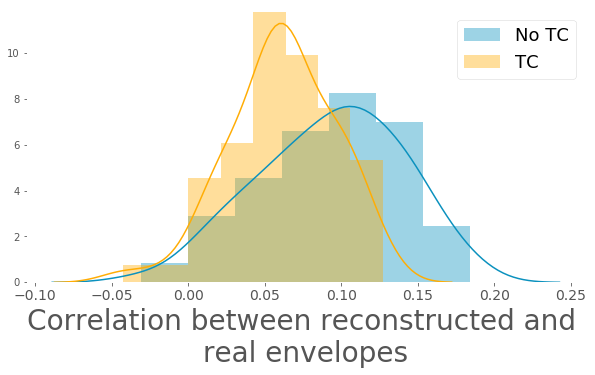

In [476]:
pylab.rcParams['figure.figsize'] = (10, 5)

flatui = ["#0B91BE", "#FFAD05"]
sns.set_palette(flatui)

corrTC = plt.figure()
sns.distplot(corrsAttended[trialsNoTCOneStream_all_good], label="No TC")
sns.distplot(corrsAttended[trialsTCOneStream_all_good], label="TC")
plt.xlabel("Correlation between reconstructed and \nreal envelopes", fontsize=28)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.legend(prop={'size': 18})

corrTC.savefig("images/corrTC.pdf", bbox_inches="tight")

A Kolmogorov-Smirnov statistical test shows that the two distributions differ (p<0.001):

In [477]:
stats.ks_2samp(corrsAttended[trialsNoTCOneStream_all_good],
               corrsAttended[trialsTCOneStream_all_good])


Ks_2sampResult(statistic=0.37709269089424258, pvalue=6.401005129451168e-05)

## Correlation right trial vs mismatch

We can assess the decoder we have made by comparing the correlations between the reconstructed envelope and the real envelope with the correlations between the reconstructed envelope with the envelope of another trial.

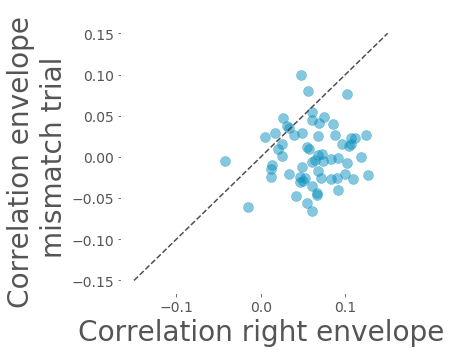

In [478]:
pylab.rcParams['figure.figsize'] = (5, 5)

corrMismatch = plt.figure()
plt.plot([-0.15, 0.15], [-0.15, 0.15], ls="--", c=".3")
plt.scatter(corrsAttended[trialsTCOneStream_all_good],
            corrsMismatch[trialsTCOneStream_all_good], s=100, alpha=0.5)
plt.xlabel('Correlation right envelope', fontsize=28)
plt.ylabel('Correlation envelope \nmismatch trial', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=14)

corrMismatch.savefig("images/corrMismatch.pdf", bbox_inches="tight")

# Exp 2 - Two streams


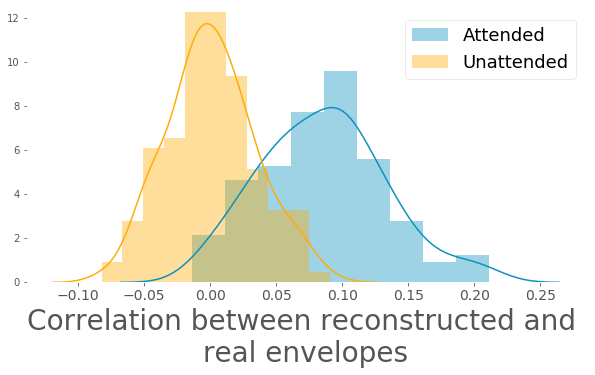

In [479]:
pylab.rcParams['figure.figsize'] = (10, 5)

flatui = ["#0B91BE", "#FFAD05"]
sns.set_palette(flatui)

corrMismatch = plt.figure()
sns.distplot(corrsAttended[trialsDualStreams_all_good], label="Attended");
sns.distplot(corrsUnattended[trialsDualStreamsOnly_all_good], label="Unattended");
plt.xlabel("Correlation between reconstructed and \nreal envelopes", fontsize=28)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.legend(prop={'size': 18})

corrMismatch.savefig("images/corrMismatch.pdf", bbox_inches="tight")

We can see that most points (corresponding to trials) are bellow the diagonal which means that the correlation between the reconstructed envelope and the right envelope is larger than the correlation between the reconstructed envelope and a wrong one.

## Link with behavior

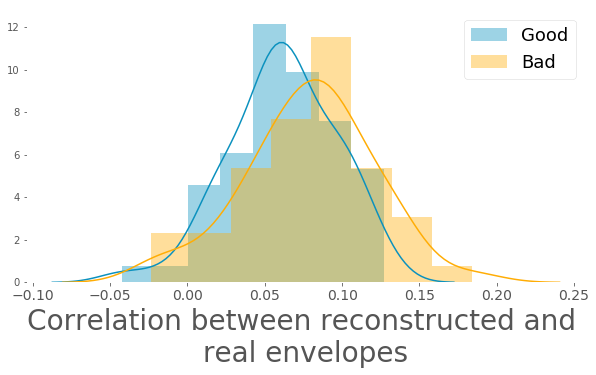

In [480]:
pylab.rcParams['figure.figsize'] = (10, 5)

flatui = ["#0B91BE", "#FFAD05"]
sns.set_palette(flatui)

corrBehavior = plt.figure()
sns.distplot(corrsAttended[trialsTCOneStream_all_good], label="Good");
sns.distplot(corrsAttended[allBadTrials.astype(int)], label="Bad");
plt.xlabel("Correlation between reconstructed and \nreal envelopes", fontsize=28)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.legend(prop={'size': 18})

corrMismatch.savefig("images/corrBehavior.pdf", bbox_inches="tight")

In [481]:
stats.ks_2samp(corrsAttended[trialsTCOneStream_all_good],
               corrsAttended[allBadTrials.astype(int)])


Ks_2sampResult(statistic=0.27354838709677426, pvalue=0.025374256847818091)

# Effect of attention

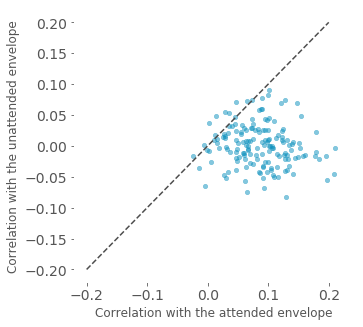

In [482]:
pylab.rcParams['figure.figsize'] = (5, 5)

plt.scatter(corrsAttended[trialsDualStreams_all],
            corrsUnattended[trialsDualStreamsOnly_all], s=20, alpha=0.5)

plt.plot([-0.2, 0.2], [-0.2, 0.2], ls="--", c=".3")
plt.xlabel('Correlation with the attended envelope')
plt.ylabel('Correlation with the unattended envelope')
plt.tick_params(axis='both', which='major', labelsize=14)

corrMismatch.savefig("images/corrMismatch.pdf", bbox_inches="tight")

# Classification

By comparing these differences in correlations between reconstructed and attended, unattended or mismatch envelopes, we can built a classifier that juste take the larger correlation and try to determine for each trial which one in the pair was the right one. 

In [1]:
trialsClassifAll = getTrialNum(
    ref=1, allSubj=True, trialBehavior=trialBehavior_p1,
)
trialsClassifDualStreams = getTrialNum(
    ref=2, allSubj=True, trialBehavior=trialBehavior_p1,
    twoStreams=[True]
)

classifMismatchTime, classifAtt_unattTime, test = getTRFAccuracyByDur(
    envAttended_all, envUnattended_all, envMismatch_all, envReconstructed_all,
    trials=trialsClassifAll, trialsDualStream=trialsClassifDualStreams
)

NameError: name 'getTrialNum' is not defined

# Plot the decoding accuracy in function of time

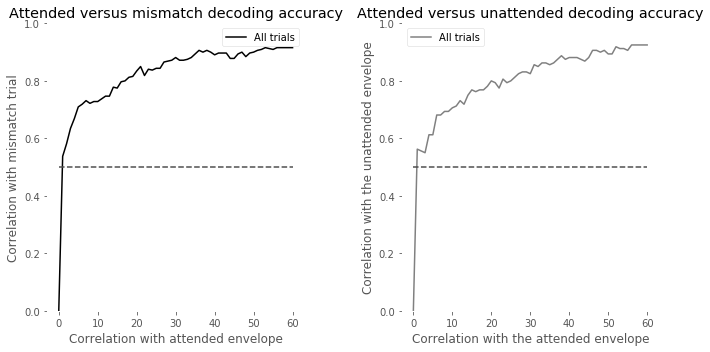

In [184]:
pylab.rcParams['figure.figsize'] = (10, 5)
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(classifMismatchTime, c='black', label='All trials')
# chance level
plt.plot([0, 60], [0.5, 0.5], ls="--", c=".3")
plt.ylim(0, 1)
plt.xlabel('Correlation with attended envelope')
plt.ylabel('Correlation with mismatch trial')
plt.title('Attended versus mismatch decoding accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(classifAtt_unattTime, c='gray', label='All trials')
# chance level
plt.plot([0, 60], [0.5, 0.5], ls="--", c=".3")
plt.ylim(0, 1)
plt.xlabel('Correlation with the attended envelope')
plt.ylabel('Correlation with the unattended envelope')
plt.title('Attended versus unattended decoding accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# SVM

We can also try to classify the trials by using a suport vector machine algorithm that will find a separation between the trials. Two features (correlations with attended and correlations with unattended) are used.

We will use a linear kernel with c=1. To do: hyper optimize c and used a train/test/validation split.

In [2]:
# Create the trials agregations
trialsTwoStreams36 = np.concatenate([np.arange(40, 60), np.arange(40, 60)+(80),
                                 np.arange(40, 60)+(80*2),
                                np.arange(40, 60)+(80*3)])
trialsTwoStreams44 = np.concatenate([np.arange(60, 80), np.arange(60, 80)+(80),
                                 np.arange(60, 80)+(80*2),
                                np.arange(60, 80)+(80*3)])
trialsTwoStreams36Unatt = np.concatenate([np.arange(20), np.arange(20)+(40),
                                 np.arange(20)+(40*2),
                                np.arange(20)+(40*3)])
trialsTwoStreams44Unatt = np.concatenate([np.arange(20, 40), np.arange(20, 40)+(40),
                                 np.arange(20, 40)+(40*2),
                                np.arange(20, 40)+(40*3)])


NameError: name 'np' is not defined

In [484]:
accAll = []
durs = np.arange(1, 61)

for dur in durs:
    corrsAttended = calculateCorr(envAttended_all, envReconstructed_all, fs=64, end=dur)
    corrsUnattended = calculateCorr(envUnattended_all,
                                    envReconstructed_all[trialsDualStreamsAll], fs=64, end=dur)

    corrs36 = np.concatenate([corrsAttended[trialsTwoStreams36],
                          corrsUnattended[trialsTwoStreams36Unatt]])
    corrs44 = np.concatenate([corrsUnattended[trialsTwoStreams44Unatt],
                             corrsAttended[trialsTwoStreams44]])

    X = np.array([corrs36,
                  corrs44]).T
    # Create labels: alternate 36 Hz trials with 44 Hz trials
    y = np.concatenate([np.repeat(36, 80), np.repeat(44, 80)])

    # Split dataset in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=0)
    # Train SVM on train data
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    # Calculate accuracy on test data
    acc = clf.score(X_test, y_test)
    accAll.append(acc)
    

Draw the accuracy in function of duration:

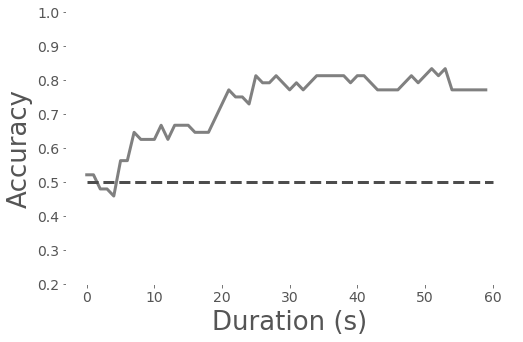

In [485]:
pylab.rcParams['figure.figsize'] = (8, 5)

decodingAcc = plt.figure()
plt.plot(accAll, c='gray', linewidth=3)
# chance level
plt.plot([0, 60], [0.5, 0.5], ls="--", c=".3", linewidth=3)
plt.ylim(0.2, 1)
plt.ylabel('Accuracy', fontsize=26)
plt.xlabel('Duration (s)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=14)

decodingAcc.savefig("images/decodingAcc.pdf", bbox_inches="tight")


### Vizualisations of the correlations 36 vs 44 Hz

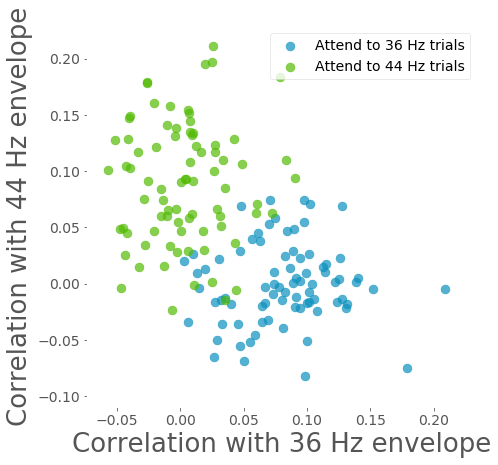

In [488]:
pylab.rcParams['figure.figsize'] = (7, 7)

flatui = ["#0B91BE", "#53BB04"]
sns.set_palette(flatui)

corrAttUnattSVM = plt.figure()
plt.scatter(X[:80,0], X[:80,1], s=80, label="Attend to 36 Hz trials", alpha=0.7)
plt.scatter(X[80:,0], X[80:,1], s=80, label="Attend to 44 Hz trials", alpha=0.7)
plt.xlabel("Correlation with 36 Hz envelope", fontsize=26)
plt.ylabel("Correlation with 44 Hz envelope", fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc=1, prop={'size': 14})

corrAttUnattSVM.savefig("images/corrAttUnattSVM.pdf", bbox_inches="tight")


We can see that 36 and 44 Hz trials are discriminable according to the correlations.

# To do: use aSSR and SR for better decoding?

In [416]:
allDurPick36 = pd.read_csv("allDurPick36.csv").values[:, 1:]
allDurPick44 = pd.read_csv("allDurPick44.csv").values[:, 1:]

In [456]:
pick36 = np.concatenate([allDurPick36[trialsTwoStreams36, :],
                allDurPick36[trialsTwoStreams44, :]])
pick44 = np.concatenate([allDurPick44[trialsTwoStreams36, :],
                allDurPick44[trialsTwoStreams44, :]])

In [457]:
X_all = np.hstack([X, pick36[:, 59].reshape(160, 1), pick44[:, 59].reshape(160, 1)])
X_all.shape

(160, 4)

In [458]:
# Split dataset in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all[:,2:], y,
                                                    test_size=0.3,
                                                    random_state=0)
# Train SVM on train data
clf = svm.SVC(kernel='linear', C=100).fit(X_train, y_train)
# Calculate accuracy on test data
acc = clf.score(X_test, y_test)
acc

0.39583333333333331